In [49]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import xgboost as xg

In [50]:
df= pd.read_csv("C:/Users/Владелец/Desktop/Data Science/[Нетология] Профессия - Data Scientist [ч.3] (2019)/ds3-spring-2018-master/3. Feature Engineering/3.3/taxi.csv", encoding ="utf-8")

In [51]:
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

In [53]:
df_dumm = pd.get_dummies(df, columns = ["offer_class_group", "ride_type_desc"])

In [54]:
df["offer_class_group"].value_counts()

#Типы(категории) такси

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [55]:
df[df["driver_response"] == 1]["offer_class_group"].value_counts() / df["offer_class_group"].value_counts()

#Economy является самой большой категорией, однако доля положительных таргетов (1) в ней далеко не самая большая. 
#В Kids значений намного меньше, однако доля вероятности положительного ответа от водителя равна почти 85%.

Delivery    0.677519
Economy     0.439040
Kids        0.840136
Premium     0.771574
Standard    0.523494
Test        0.750000
VIP         0.773333
VIP+        0.896552
XL          0.711207
Name: offer_class_group, dtype: float64

In [72]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (df_train[df_train[target_col] ==1][col].value_counts() / df_train[col].value_counts()).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

#Здесь определяем соотношение категориальных фич Counts(см. ФИЧАИНЖЕНЕРИНГ)
#Тест не трогаем. Все данные о соотношении делаются на train, после чего соотношения из train идут в те же категории в тест.

In [57]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

#Считаем WEIGH OF EVIDENCE.

In [58]:
def get_woe_stat(df_train, col, target_col):
    stat = df_train.groupby(col)[target].agg(
        [np.mean, np.size, np.count_nonzero], sort=False
    )
    stat.rename(columns={'count_nonzero': 'good', 'size': 'obs', 'mean': 'event_rate'}, inplace=True)
    stat['all_good'] = stat['good'].sum()
    stat['p_good'] = stat['good'] / stat['all_good']
    stat['bad'] = stat['obs'] - stat['good']
    stat['all_bad'] = stat['bad'].sum()
    stat['p_bad'] = stat['bad'] / stat['all_bad']
    stat['WOE']=np.log(stat['p_good'] / stat['p_bad'])
    stat['IV'] = ((stat['p_good'] - stat['p_bad']) * stat['WOE']).sum()
    stat['variable'] = col
    stat['category'] = stat.index
    stat.reset_index(inplace=True)
    stat.drop(labels=col, inplace=True, axis=1)
    return stat


#Считаем INFORMATION VALUE.

In [59]:
def process_hour(hour):
    if 6 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    elif 0 <= hour < 6:
        return 3
    
#creating categories based on the part of the day

In [60]:
def process_day(day):
    if day <= 4:
        return 0
    else:
        return 1

#Weekend или нет. 

In [61]:
def compute_taxi_cost(row):
    if row.offer_class_group == "Economy":
        return 97 + 7 * row.distance_km + 7 * row.duration_min
    elif row.offer_class_group == "Standard":
        return 150 + 11 * row.distance_km + 13 * row.duration_min
    elif row.offer_class_group == "Premium":
        return 299 + 15 * row.distance_km + 20 * row.duration_min
    elif row.offer_class_group == "Kids":
        return 99 + 22 * row.duration_min
    elif row.offer_class_group == "VIP":
        return 699 + 55 * row.distance_km + 25 * row.duration_min
    elif row.offer_class_group == "XL":
        return 299 + 15 * row.distance_km + 25 * row.duration_min
    else:
        return -1
    
#Считаем стоимость - не помню откуда взял данные. 


In [62]:
def new_columns(df):
    df['day_part'] = df.apply(lambda row: process_hour(row.hour_key), axis=1)
    df['week_part'] = df.apply(lambda row: process_day(row.hour_key), axis=1)
    df['taxi_cost'] = df.apply(lambda row: compute_taxi_cost(row), axis=1)
    return df

#Добавляем новые/переделанные фичи. 

In [63]:
new_d = {"Economy" : 2, "Standard": 3,"Premium": 4, "Delivery": 1, "Kids":5, "XL":6, "VIP": 7, "VIP+":8, "Test" :0}

df = new_columns(df)

df["offer_class_group"] = df["offer_class_group"].replace(new_d)

df = df.drop("ride_type_desc", axis = 1)

In [64]:
df.sample()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,driver_response,day_part,week_part,taxi_cost
73832,1051756,5,23,462,402265,55.962084,37.417515,55.964892,37.413543,-1.0,-1.0,3,0,2,1,126.0


In [65]:
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,driver_response,day_part,week_part,taxi_cost
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,2.544470,0.492480,1.609330,0.836510,522.106370
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.674112,0.499946,0.966756,0.369814,1482.017217
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,2.000000,0.000000,1.000000,1.000000,126.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,3.000000,0.000000,2.000000,1.000000,373.770500
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,3.000000,1.000000,2.000000,1.000000,731.165000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,8.000000,1.000000,3.000000,1.000000,386252.190000


In [66]:
df.corr()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,driver_response,day_part,week_part,taxi_cost
offer_gk,1.000000,-0.004506,-0.006948,0.001475,0.003331,-0.003075,-0.003615,-0.005472,-0.006779,-0.002370,-0.002259,-0.001475,0.005156,-0.000728,-0.004058,-0.002447
weekday_key,-0.004506,1.000000,0.047880,0.011147,0.000738,-0.000230,0.006484,-0.010530,0.010081,-0.029313,-0.030534,0.013772,0.038610,-0.047468,0.058967,-0.015855
hour_key,-0.006948,0.047880,1.000000,-0.037363,0.006163,0.000306,-0.006990,0.008156,-0.016224,-0.020857,-0.026189,0.009809,0.019533,-0.102348,0.754908,-0.009145
driver_gk,0.001475,0.011147,-0.037363,1.000000,-0.004144,-0.026871,-0.004116,-0.031577,0.042773,-0.009581,-0.004083,-0.035821,0.015728,-0.033689,-0.008521,-0.004847
order_gk,0.003331,0.000738,0.006163,-0.004144,1.000000,0.004519,0.003259,0.005538,0.001282,0.002121,0.003198,0.004103,0.001663,0.002441,0.002479,0.000279
driver_latitude,-0.003075,-0.000230,0.000306,-0.026871,0.004519,1.000000,0.986198,0.031568,-0.036470,0.010341,0.015991,-0.018261,-0.051948,0.019382,-0.008656,0.005963
driver_longitude,-0.003615,0.006484,-0.006990,-0.004116,0.003259,0.986198,1.000000,-0.003323,0.017067,0.013402,0.023337,-0.019230,-0.019828,0.008519,-0.009553,0.007476
origin_order_latitude,-0.005472,-0.010530,0.008156,-0.031577,0.005538,0.031568,-0.003323,1.000000,0.856676,-0.000900,-0.005915,0.000806,-0.049377,0.030031,-0.008799,-0.000405
origin_order_longitude,-0.006779,0.010081,-0.016224,0.042773,0.001282,-0.036470,0.017067,0.856676,1.000000,0.009741,0.018311,-0.001025,0.053248,-0.003552,-0.013291,0.005079
distance_km,-0.002370,-0.029313,-0.020857,-0.009581,0.002121,0.010341,0.013402,-0.000900,0.009741,1.000000,0.977033,-0.017821,-0.140969,0.097647,-0.072466,0.805050


In [68]:
y = df["driver_response"]

X = df.drop("driver_response", axis = 1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [80]:
columns_to_get_counts = ['driver_gk',"day_part","offer_class_group"]
    
for col_get_prob in columns_to_get_counts:
    X_train, X_test = get_counts(X, y, col_get_prob, df.driver_response)

KeyError: "None of [Int64Index([0, 1, 0, 1, 1, 0, 1, 0, 0, 0,\n            ...\n            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n           dtype='int64', length=100000)] are in the [columns]"

In [85]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
y_test_predict = xgb.predict_proba(X_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.92
Test:  0.9


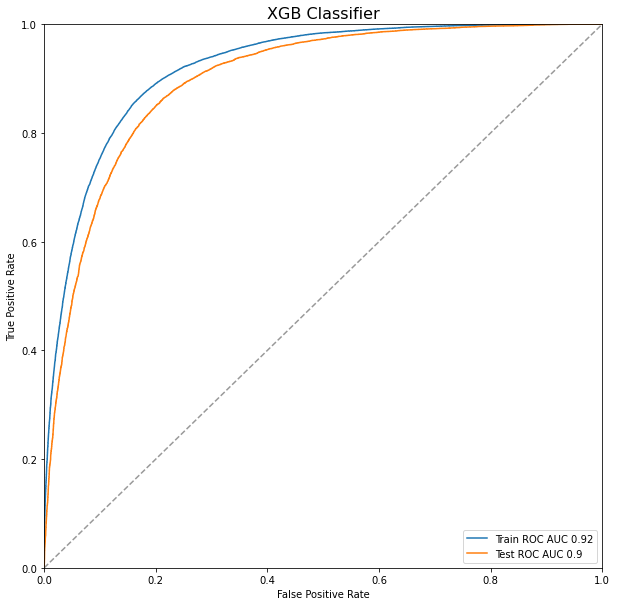

In [87]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

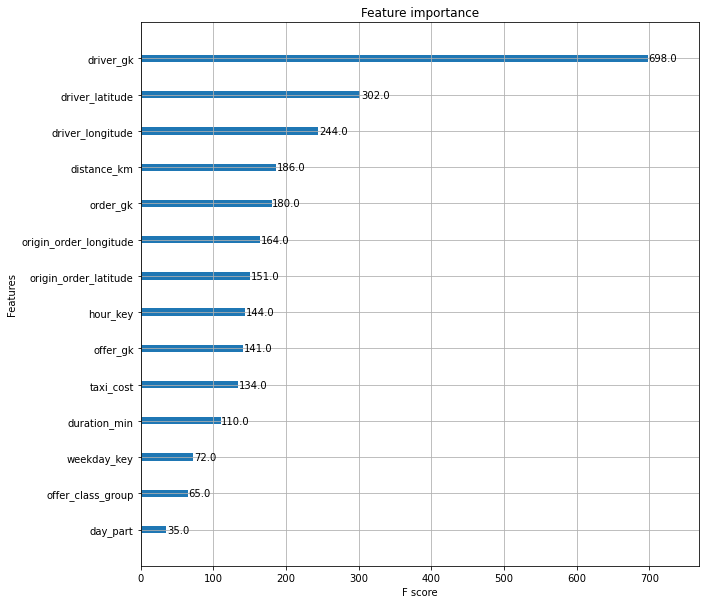

In [89]:
plt.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')